<a href="https://colab.research.google.com/github/shaghayegh5ghasemi/supervised_fuzzy_clustering/blob/main/Supervised_Fuzzy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def make_window(img, label):
  # windows = img.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
  # selected_windows = []
  # for n in range(2):
  #   i = torch.randint(0, 14, (1, 1))
  #   j = torch.randint(0, 14, (1, 1))
  #   temp = windows[:, i[0, 0], j[0, 0]].reshape((27, 1))
  #   selected_windows.append([temp, label])
  # return selected_windows
  windows = img.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
  test = []
  for i in range(15):
    for j in range(15):
      temp = windows[:, i, j].reshape((27, 1))
      test.append([temp, label])
  return test

def make_dataset():
  dataset = []
  my_labels = [torch.tensor(0), torch.tensor(1), torch.tensor(2)]
  c = [0, 0, 0]
  for i, (inputs, labels) in enumerate(trainloader):
    if c[0] == 5 and c[1] == 5 and c[2] == 5:
      break
    if labels in my_labels:
      if c[labels[0]] == 5:
          continue
      else:
        c[labels[0]] += 1
        dataset = dataset + make_window(inputs[0], labels[0])
  return dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [ ]:
# load data
trainset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(dataset=trainset, batch_size=1, shuffle=True)
testset = datasets.CIFAR10(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
testloader = DataLoader(dataset=testset, batch_size=1, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# dataset keeps our windows, class_label_matrix keeps the label of windows
dataset = []
class_label_matrix = []

# centroid and cov of each cluster
centroids = []
covariances = []
inverted_covariances = []

# initialize the centroids and the parameters
number_of_dimensions = 27
number_of_classes = 3 #len(classes)

gamma = 1
sigma = 0.9
threshold = 0.2
beta = 1

In [ ]:
# plot the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def make_window(dataset, class_label_matrix, img, label, number_of_classes):
  windows = img.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
  for i in range(15):
    for j in range(15):
      dataset.append(windows[:, i, j].reshape((27)))
      temp = [0]*number_of_classes
      temp[label] = 1
      class_label_matrix.append(temp)

In [ ]:
def make_dataset(dataset, class_label_matrix):
  my_labels = [torch.tensor(0), torch.tensor(1), torch.tensor(2)]
  c = [0, 0, 0]
  for i, (inputs, labels) in enumerate(trainloader):
    if c[0] == 6 and c[1] == 6 and c[2] == 6:
      break
    if labels in my_labels:
      if c[labels[0]] == 6:
          continue
      else:
        c[labels[0]] += 1
        make_window(dataset, class_label_matrix, inputs[0], labels[0], 3)

In [ ]:
make_dataset(dataset, class_label_matrix)
dataset = torch.stack(dataset)
class_label_matrix = np.array(class_label_matrix, dtype="float32")

In [ ]:
def calculate_mahanalobis_distance(icm, m, x):
  # D^2 = (x-m)^T * C^-1 * (x-m), mahanalobis distance formula
  s = x-m
  return s.T@icm@s

In [ ]:
def initialize_centroids(dataset, centroids, inverted_covariances, covariances, number_of_dimensions, gamma, sigma, threshold):
  number_of_centroids = len(centroids)
  for data in dataset:
    if number_of_centroids == 0:
      number_of_centroids += 1
      centroids.append(data)
      covariances.append(sigma*torch.eye(number_of_dimensions))
      inverted_covariances.append(torch.eye(number_of_dimensions)/sigma)
    else:
      distances = []
      for i in range(number_of_centroids):
        distances.append(calculate_mahanalobis_distance(inverted_covariances[i], centroids[i], data[i]))
      distances = -1*gamma*np.array(distances)
      RM = np.exp(distances)
      if max(RM) < threshold:
        number_of_centroids += 1
        centroids.append(data)
        covariances.append(sigma*torch.eye(number_of_dimensions))
        inverted_covariances.append(torch.eye(number_of_dimensions)/sigma)

In [ ]:
initialize_centroids(dataset, centroids, inverted_covariances, covariances, number_of_dimensions, gamma, sigma, threshold)
q = np.zeros((len(centroids), 3), dtype="float32") # matrix that contains the probibilities number of clusters x number of classes
miu_ik = np.zeros((len(dataset), len(centroids)), dtype="float32") # matrix that contains the memberships number of samples x number of clusters

In [ ]:
print(len(centroids))

14


In [ ]:
def calculate_membership(icm, vi, x, gamma):
  distance = calculate_mahanalobis_distance(icm, vi, x)
  if np.exp(-1*gamma*distance) < 0.0001:
    return np.array(0.0001)
  else:
    return np.exp(-1*gamma*distance)

In [ ]:
def calculate_membership_matrix(dataset ,centroids, inverted_covariances, miu_ik, gamma):
  for i in range(len(centroids)):
    for j in range(len(dataset)):
      miu_ik[j][i] = calculate_membership(inverted_covariances[i], centroids[i], dataset[j], gamma)
  # normalize the matirx
  sum_of_rows = miu_ik.sum(axis=1)
  miu_ik = miu_ik/sum_of_rows[:, np.newaxis]
  miu_ik = miu_ik.astype(np.float32)

In [ ]:
def update_centroids(dataset, centroids, inverted_covariances, miu_ik, q, gamma, beta):
  calculate_membership_matrix(dataset ,centroids, inverted_covariances, miu_ik, gamma)
  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = np.sum(temp, 0).reshape(1, 3) 
    q[i, :] = cnt/np.sum(cnt)
    temp2 = np.sum(q[i, :]*class_label_matrix, 1).reshape(len(dataset), 1)*miu_ik[:, [i]]
    temp3 = np.transpose(temp2)@dataset.cpu().detach().numpy()
    centroids[i] = (1-beta)*centroids[i] + beta*(temp3[0])/np.sum(temp2)

In [ ]:
def calculate_inverted_covariance(covariance):
  covariance = np.array(covariance)
  l, mygamma = np.linalg.eig(covariance) # calculate eigenvalues and eigenvectors
  mylambda = np.zeros((l.shape[0], l.shape[0])) # construct a diagnosal matrix with eigenvalues
  for i in range(l.shape[0]):
    if l[i] < 0.00001:
      mylambda[i][i] = np.float32(0)
    else:
      mylambda[i][i] = np.float32(1/l[i])
  icm = (mygamma)@(mylambda)@(mygamma.T) # invert of the covariance matrix
  icm = np.float32(icm)
  return torch.tensor(icm)

In [ ]:
def update_covariances(dataset, centroids, covariances, inverted_covariances, q, classes, gamma, beta):
  calculate_membership_matrix(dataset ,centroids, inverted_covariances, miu_ik, gamma)
  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = np.sum(temp, 0).reshape(1, 3) # shape ino havaset basheeeeeeeeeeeeeeeeeee
    q[i, :] = cnt/np.sum(cnt)
    temp2 = np.sum(q[i, :]*class_label_matrix, 1).reshape(len(dataset), 1)*miu_ik[:, [i]]

    x_clusteri = dataset - centroids[i]
    temp3 = np.transpose(temp2*x_clusteri.cpu().detach().numpy())@(x_clusteri.cpu().detach().numpy())
    covariances[i] = (1-beta)*covariances[i] + beta*temp3/np.sum(temp2)
    inverted_covariances[i] = calculate_inverted_covariance(covariances[i])

In [ ]:
def calculate_entropy(dataset, centroids, inverted_covariances, classes, q, gamma):
  ent = -1*np.sum(np.mean(q*np.log(q + 0.00001), axis=0))
  return ent

In [ ]:
entropy_curve = []
for i in range(50):
  update_centroids(dataset, centroids, inverted_covariances, miu_ik, q, gamma, beta)
  update_covariances(dataset, centroids, covariances, inverted_covariances, q, classes, gamma, beta)
  entropy = calculate_entropy(dataset, centroids, inverted_covariances, classes, q, gamma)
  entropy_curve.append(entropy)
  print(entropy)

1.0552418231964111
0.5778627395629883
0.6894226670265198
0.22550147771835327
0.6314082145690918
0.20046202838420868
0.48970434069633484
0.16388745605945587
0.5346106290817261
0.17980867624282837
0.551712155342102
0.20961034297943115
0.5142396688461304
0.20627713203430176
0.4580202102661133
0.18613293766975403
0.5484858751296997
0.22361797094345093
0.4258238673210144
0.20034676790237427
0.4305364489555359
0.21690824627876282
0.43435919284820557
0.23569053411483765
0.39665448665618896
0.22401636838912964
0.3795589804649353
0.23388700187206268
0.3350941836833954
0.2398446500301361
0.299407958984375
0.26617729663848877
0.29103919863700867
0.2696373462677002
0.29762667417526245
0.27134382724761963
0.28643226623535156
0.27654463052749634
0.28932738304138184
0.2723432183265686
0.2922021746635437
0.2730335295200348
0.28851863741874695
0.27329182624816895
0.2842986285686493
0.27078795433044434
0.2813170254230499
0.2760869264602661
0.2738197445869446
0.2796539068222046


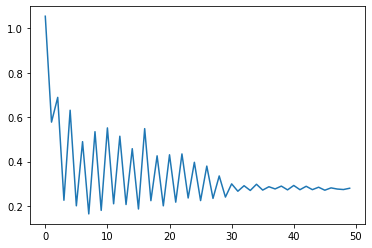

In [ ]:
import matplotlib.pyplot as plt
plt.plot(entropy_curve)
plt.show()

    c a r


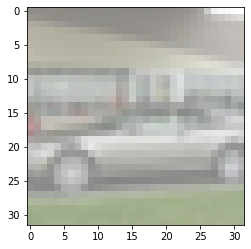

window number 1 belongs to cluster 1
window number 2 belongs to cluster 1
window number 3 belongs to cluster 1
window number 4 belongs to cluster 1
window number 5 belongs to cluster 1
window number 6 belongs to cluster 1
window number 7 belongs to cluster 1
window number 8 belongs to cluster 1
window number 9 belongs to cluster 1
window number 10 belongs to cluster 1
window number 11 belongs to cluster 1
window number 12 belongs to cluster 1
window number 13 belongs to cluster 1
window number 14 belongs to cluster 1
window number 15 belongs to cluster 1
window number 16 belongs to cluster 1
window number 17 belongs to cluster 1
window number 18 belongs to cluster 1
window number 19 belongs to cluster 1
window number 20 belongs to cluster 1
window number 21 belongs to cluster 1
window number 22 belongs to cluster 1
window number 23 belongs to cluster 1
window number 24 belongs to cluster 1
window number 25 belongs to cluster 1
window number 26 belongs to cluster 1
window number 27 belo

In [ ]:
label = torch.tensor(12)
for i, (inputs, labels) in enumerate(testloader):
  if label != torch.tensor(12):
    break
  if labels[0] in [torch.tensor(0), torch.tensor(1), torch.tensor(2)]:
    image = inputs[0]
    label = labels[0]
print(' '.join('%5s' % classes[label]))
imshow(torchvision.utils.make_grid(image))

windows = image.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
test = []
for i in range(15):
  for j in range(15): 
    test.append(windows[:, i, j].reshape(27))

windows_max_membership = []
for w in test:
  memberships = []
  for i in range(len(centroids)):
    memberships.append(calculate_membership(inverted_covariances[i], centroids[i], w, gamma))
  windows_max_membership.append(np.argmax(memberships))


for i in range(len(test)):
  print(f'window number {i+1} belongs to cluster {windows_max_membership[i] + 1}')
  
